In [1]:
#VERSIE 2 VAN TESTING, Nienke en Ema hebben hier onze aanpassingen doorgevoerd, dus oude aanpassingen staan in vorige versie

In [2]:
#import needed libraries
import pandas as pd
import rdkit
import main
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

In [3]:
#test printing molecule
smiles = ['COC(=O)c1c[nH]c2cc(OC(C)C)c(OC(C)C)cc2c1=O', "COC(=O)c1c[nH]c2cc(OC(C)C)c(OC(C)C)cc2c1=O"]

mols = [Chem.MolFromSmiles(smi) for smi in smiles]
Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(200, 200))

In [4]:
#import data
data_raw = pd.read_csv('tested_molecules.csv')
data_raw

In [5]:
# Create dataframe
expanded_df = main.create_dataframe(data_raw)
expanded_df.head()

In [6]:
# verwijderen van PKM2_inhibition en ERK2_inhibition, want dit zijn de labels en dit is enkel nodig om het deep learning model te trainen
expanded_df = expanded_df.drop(columns = ['PKM2_inhibition','ERK2_inhibition'])
expanded_df

In [7]:
expanded_df.describe()



In [8]:
# checken of er outliers zijn door boxplots te maken
expanded_df.describe()

# checken of we geen missing values hebben
nan_counts = expanded_df.columns[expanded_df.isnull().any()].tolist()
print(nan_counts)

# checken of er lijsten zijn die enkel dezelfde waarde bevat
non_variating_columns = expanded_df.columns[expanded_df.nunique()==1].tolist()
print(len(non_variating_columns))

# omdat de hele lijst geen variatie vertoont verwijderen we hem want dan kan er op basis van deze variabelen ook geen onderscheid worden gemaakt tussen de moleculen
expanded_df.drop(columns = non_variating_columns, inplace = True)
expanded_df.describe()


In [9]:
# Controleren op normaal verdeeldheid
normality_results = main.check_normality(expanded_df.iloc[:,1:])

# Print resultaten
for column, p_value in normality_results.items():
    if p_value > 0.05:
        print(f"Kolom {column} is normaal verdeeld (p-waarde = {p_value:.5f})")
print('Done')

# geen enkele variabele is dus normaal verdeeld --> standard scaling is naar onze mening dus geen goed idee, wij zouden voor min-max gaan

scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(expanded_df.iloc[:,1:])
scaled_df = pd.DataFrame(scaled_array, columns=expanded_df.iloc[:,1:].columns)

# Weergeven van de geschaalde DataFrame
scaled_df.describe()

# scaled_df heeft niet meer de SMILES erin staan

In [10]:
# plotten van min-max scaled values
plt.figure(figsize=(40, 12))
scaled_df.boxplot(rot=90)
plt.title('Boxplot van elke variabele')
plt.ylabel('Waarden (min-max geschaald)')
plt.xlabel('Variabelen')
plt.show()

In [11]:
# Hier moeten nog de outliers uitgehaald worden
# Function to calculate number of outliers in a column
def count_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((column < lower_bound) | (column > upper_bound)).sum()
    return outliers

# Apply the function to each column
outliers_per_column = expanded_df.iloc[:, 1:].apply(count_outliers)
print("Number of outliers per column:")
print(outliers_per_column)

In [12]:
# use PCA
pca = PCA()
pca.fit(scaled_df)




In [13]:
# MinMaxScaler

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(cumulative_variance) + 1), cumulative_variance, alpha=0.5, align='center')

plt.axhline(y=0.9,color='r',linestyle='-')
plt.xlabel('Principal component (PC)')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('cumulative explained variance for each principal component')

plt.show()

In [14]:
# Kijken welke het belangrijkste is in pc1
important_idx = np.argmax(np.abs(pca.components_[0]))
important_feature = scaled_df.columns[important_idx]
important_feature

In [15]:
# Kijken welke het minst belangrijkste is
important_idx = np.argmin(np.abs(pca.components_[0]))
important_feature = scaled_df.columns[important_idx]
important_feature

In [16]:
# Nummer of Principal Components bij MinMaxScaling
num_components = np.argmax(cumulative_variance >= 0.80) + 1
num_components

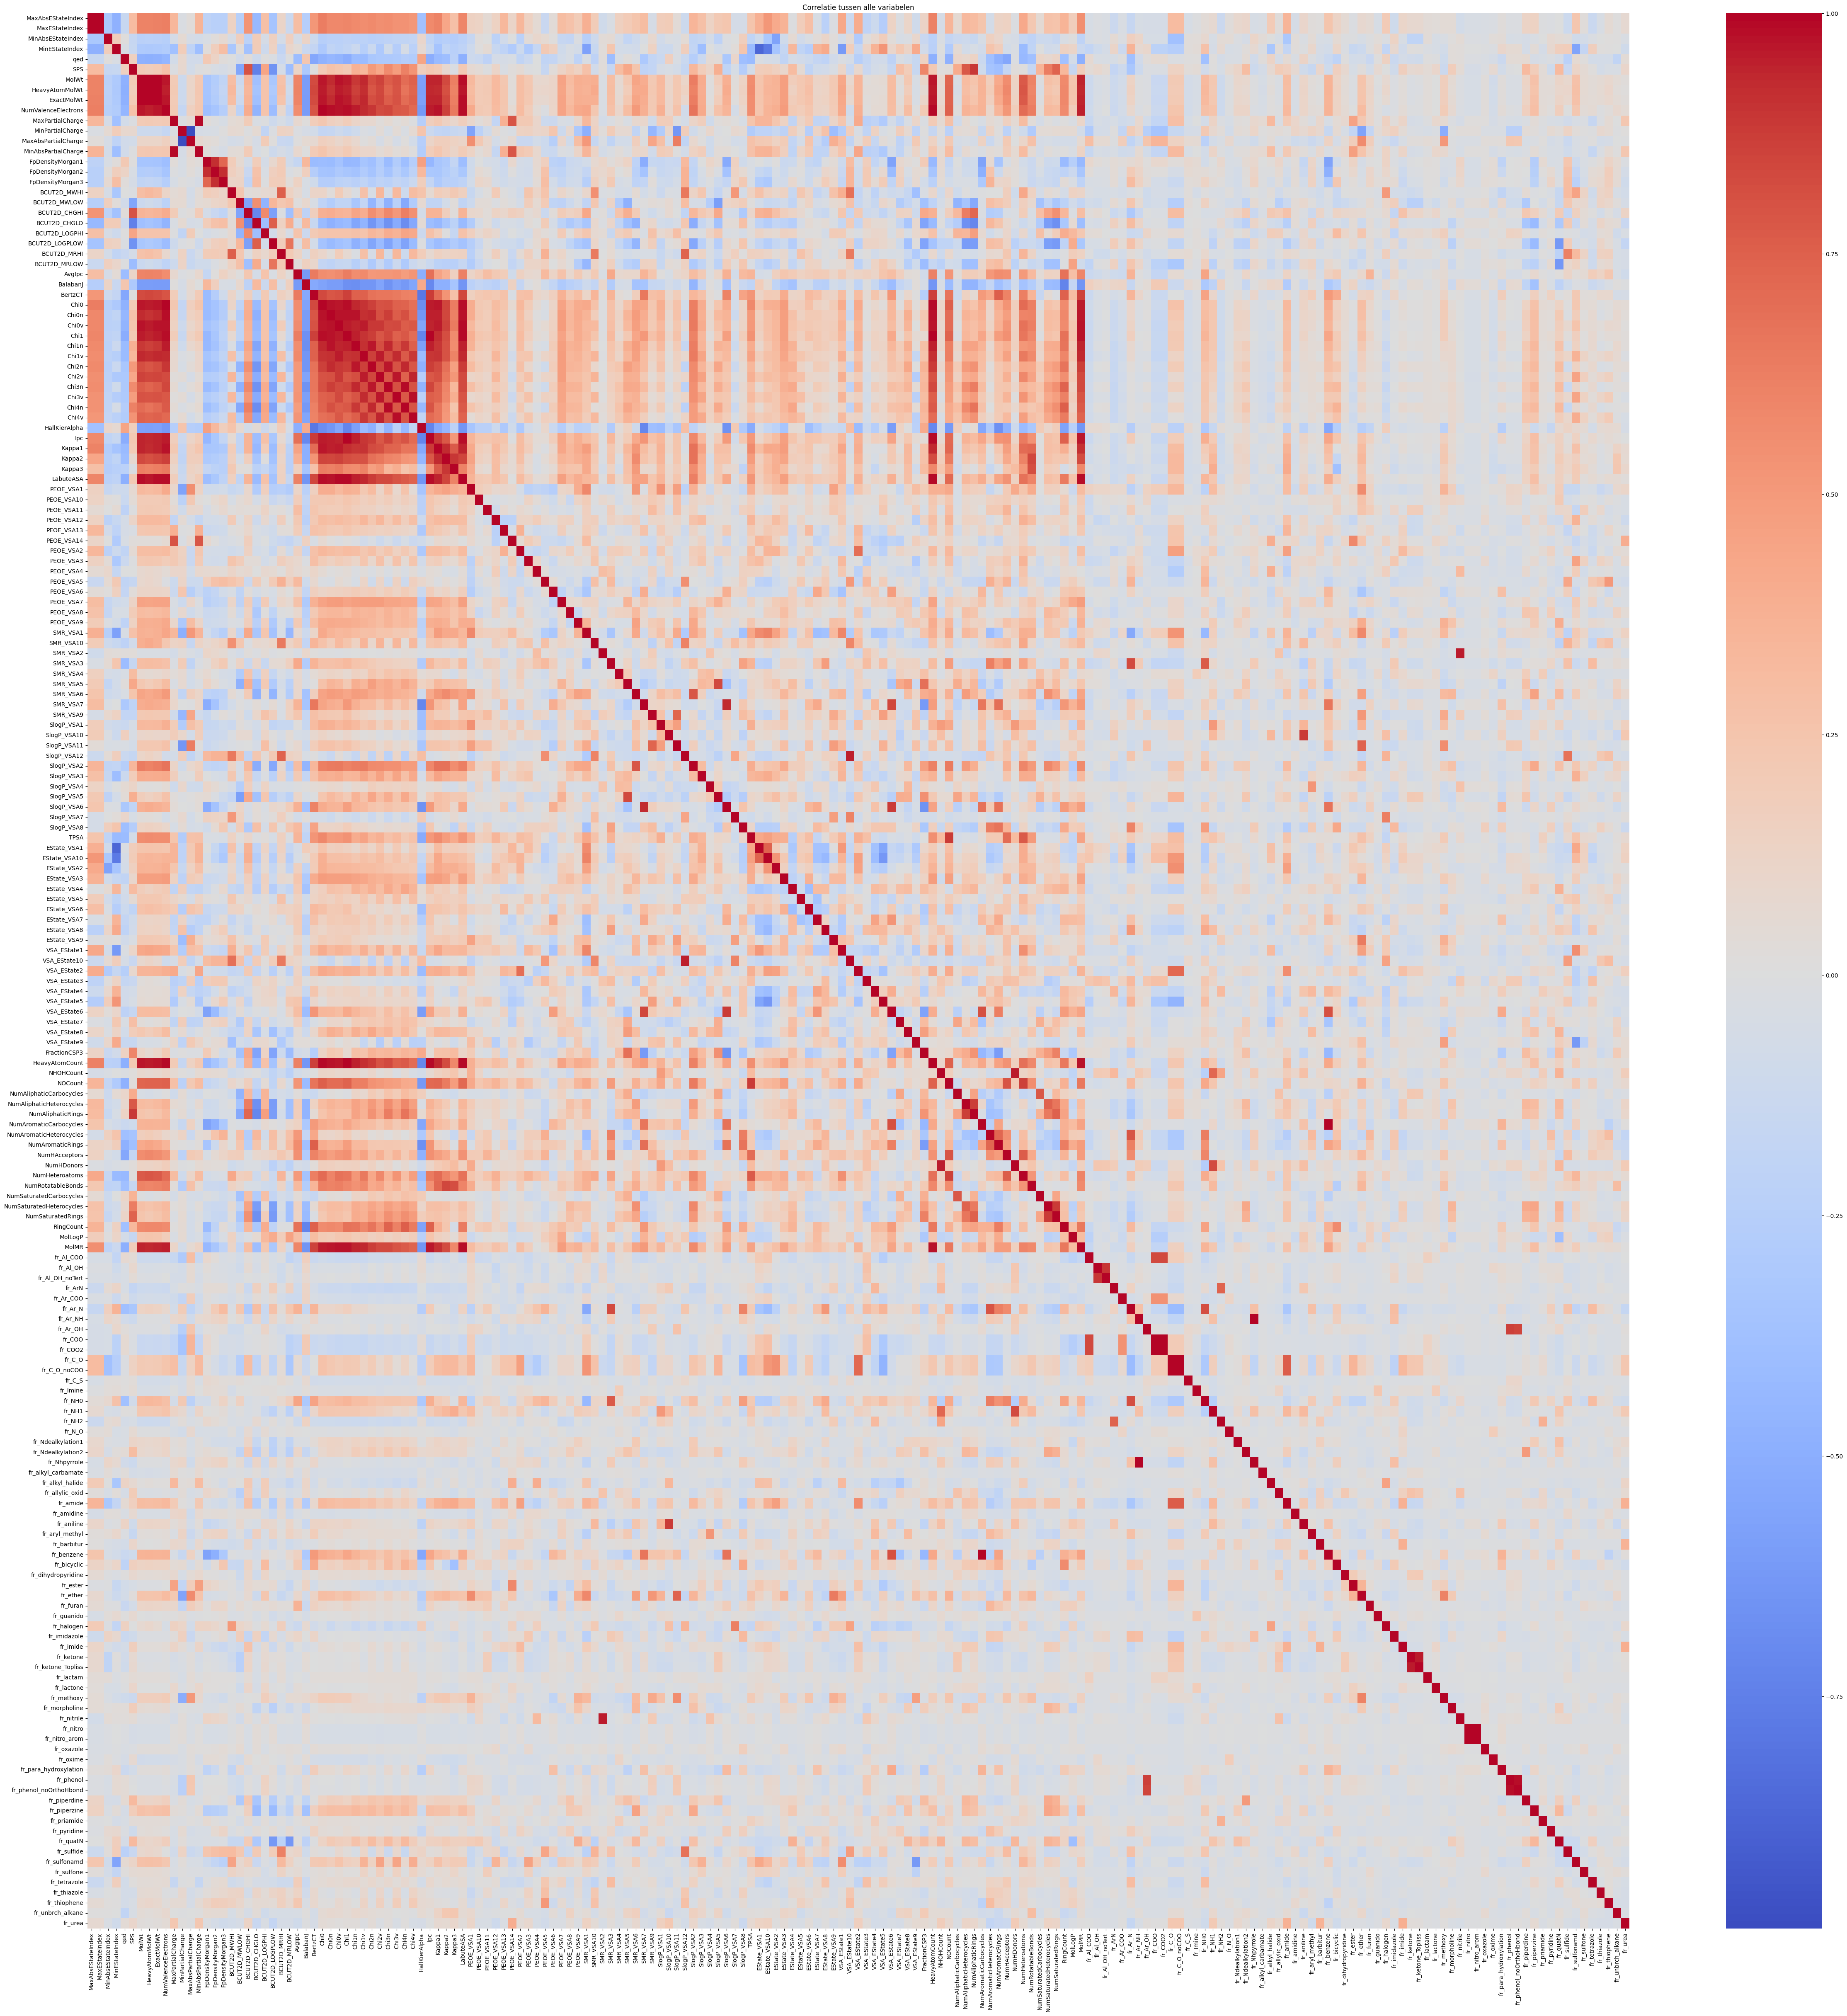

In [19]:
# voor spearman gekozen want geen normality assumed
correlation_matrix = expanded_df.iloc[:,1:].corr(method = 'spearman')

# Maak de heatmap
plt.figure(figsize=(60, 60))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlatie tussen alle variabelen')
plt.show()

# wij denken dat een zo laag mogelijke correlatie beter is, omdat sterk gerelateerde variabelen geen extra informatie geven

In [18]:
# wij denken dat we vanaf hier aan stap 3 moeten beginnen en een model voor het deep learning gedeelte moeten 
#schrijven om te selecteren welke variabelen het belangrijkste zijn